In [ ]:
!pip install pandas numpy pyarrow requests tqdm pyranges --quiet
# Download GDC client
!wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip -O gdc.zip -q
!unzip -o gdc.zip > /dev/null
!chmod +x gdc-client
print("Installed Python deps and downloaded gdc-client.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Installed Python deps and downloaded gdc-client.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
print(" Google Drive mounted at /content/drive")

Mounted at /content/drive
 Google Drive mounted at /content/drive


In [4]:
from pathlib import Path
import os
import pandas as pd
from transformers import (
    BertConfig,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    TrainerCallback
)

# Main project root on Google Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/bdh_challenge_2025_data")
PROJECT_ROOT.mkdir(exist_ok=True)

# Data directories
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# Directory where raw TCGA STAR count files will be stored
RNA_DIR = PROJECT_ROOT / "tcga_rna"
RNA_DIR.mkdir(exist_ok=True)

# Directory where processed matrices, tokenized data, embeddings
PROCESSED_DIR = PROJECT_ROOT / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

print("Project root :", PROJECT_ROOT)
print("DATA_DIR     :", DATA_DIR)
print("RNA_DIR      :", RNA_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)

Project root : /content/drive/MyDrive/bdh_challenge_2025_data
DATA_DIR     : /content/drive/MyDrive/bdh_challenge_2025_data/data
RNA_DIR      : /content/drive/MyDrive/bdh_challenge_2025_data/tcga_rna
PROCESSED_DIR: /content/drive/MyDrive/bdh_challenge_2025_data/processed


In [ ]:
ALIGNED_PATH = PROCESSED_DIR / "tcga_tpm_like_log10_bulkrnabert_aligned.parquet"
expr_aligned = pd.read_parquet(ALIGNED_PATH)

In [ ]:
expr_aligned

gene_id,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000284519,ENSG00000284532,ENSG00000284535,ENSG00000284543,ENSG00000284557,ENSG00000284564,ENSG00000284574,ENSG00000284587,ENSG00000284595,ENSG00000284596
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-P5-A5EY,1.681527,0.063817,1.141174,0.877901,0.408766,0.778577,0.989684,1.165323,1.534292,1.396228,...,0.0,0.0,0.0,0.008509,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AR-A1AW,1.605939,0.088174,1.567791,1.419358,1.132621,1.467036,2.035625,1.477680,1.519647,1.800230,...,0.0,0.0,0.0,0.254434,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-E9-A1N5,1.848499,0.367775,1.398195,1.432945,0.981104,1.023865,1.629135,1.540959,1.538390,1.612078,...,0.0,0.0,0.0,0.189368,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-97-7941,2.254924,0.079794,1.397967,1.311801,0.662706,1.375285,1.929090,1.767373,1.938894,1.489701,...,0.0,0.0,0.0,0.393385,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-93-7347,1.395531,0.035987,1.261120,1.125617,0.640414,1.382043,1.897127,1.634034,1.067374,1.466133,...,0.0,0.0,0.0,0.241292,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-PQ-A6FN,1.967442,0.000000,1.796011,0.847344,0.999576,0.946174,1.487409,1.717826,2.103600,1.397338,...,0.0,0.0,0.0,0.108074,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-GC-A4ZW,2.229213,0.000000,1.749333,1.162980,1.209287,0.670079,0.779123,2.077857,1.689240,1.659367,...,0.0,0.0,0.0,1.530551,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-91-6840,2.262706,0.046630,1.733062,1.263441,1.205125,1.215238,1.586505,1.909207,1.408809,1.954489,...,0.0,0.0,0.0,0.088735,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertForMaskedLM, PreTrainedModel, BertModel

CONFIG = {
    "N_genes": 19062,
    "n_embedding": 256,
    "n_layers": 4,
    "n_heads": 8,
    "n_bins": 64,
    "vocab_size": 70,
    "mask_prob": 0.15,
    "batch_size_eff": 3e6,
    "batch_size": 16,
    "hv_genes_count": 12403,
    "grad_accum": 4,
    "lr": 1e-4,
    "max_steps": 10000,
}

In [ ]:
class RNAPreprocessor:
    def __init__(self, num_bins=64):
        self.num_bins = num_bins
        self.global_max = None
        self.bin_edges = None

    def fit_transform(self, data):

        # 1. Log Transform
        transformed = data # np.log10(1 + data)

        # 2. Max Normalization (Global)
        self.global_max = np.max(transformed)
        normalized = transformed / self.global_max

        # 3. Binning
        self.bin_edges = np.linspace(0, 1, self.num_bins + 1)
        binned = np.digitize(normalized, self.bin_edges) - 1
        binned = np.clip(binned, 0, self.num_bins - 1)

        # Shift +5 for special tokens (0-4 reserved)
        return binned + 5

class BulkRNADataset(Dataset):
    def __init__(self, tokenized_data, survival_time=None, event_indicator=None):
        self.data = torch.tensor(tokenized_data, dtype=torch.long)
        self.survival_time = torch.tensor(survival_time, dtype=torch.float) if survival_time is not None else None
        self.event = torch.tensor(event_indicator, dtype=torch.float) if event_indicator is not None else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {"input_ids": self.data[idx]}
        if self.survival_time is not None:
            item["time"] = self.survival_time[idx]
            item["event"] = self.event[idx]
        return item

In [ ]:
# 4. PRE-TRAINING (Masked Language Model)

class MockTokenizer:
    """
    A dummy tokenizer that satisfies all DataCollator requirements:
    1. Provides special token attributes.
    2. Implements padding (stacking tensors).
    3. Identifies special tokens so they aren't masked.
    """
    def __init__(self, vocab_size, mask_token_id=4, pad_token_id=0):
        self.vocab_size = vocab_size
        self.mask_token_id = mask_token_id
        self.pad_token_id = pad_token_id

        # Attributes required by DataCollator checks
        self.mask_token = "[MASK]"
        self.pad_token = "[PAD]"

        # Prevents truncation warnings
        self.model_max_length = 100_000

    def __len__(self):
        return self.vocab_size

    def pad(self, encoded_inputs, return_tensors="pt", **kwargs):
        """
        Called by DataCollator to stack a list of samples into a batch.
        Since our gene expression data is fixed-length (N_genes), we just stack them.
        """
        import torch

        # encoded_inputs is a list of dicts: [{'input_ids': tensor}, {'input_ids': tensor}]
        batch = {}

        # We take the first sample to know the keys (usually just 'input_ids')
        for key in encoded_inputs[0].keys():
            # Extract values for this key from all samples
            values = [d[key] for d in encoded_inputs]

            # If they are already tensors, stack them. If lists, convert to tensor.
            if isinstance(values[0], torch.Tensor):
                batch[key] = torch.stack(values)
            else:
                batch[key] = torch.tensor(values, dtype=torch.long)

        return batch

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Called by DataCollator to decide what NOT to mask.
        We treat IDs 0 to 4 as special (PAD, UNK, CLS, SEP, MASK).
        Returns: list of 0s (can mask) and 1s (cannot mask).
        """
        # token_ids_0 is a list of integers
        return [1 if token < 5 else 0 for token in token_ids_0]

    def convert_tokens_to_ids(self, token):
        return self.mask_token_id if token == self.mask_token else 0

    def save_pretrained(self, save_directory):
        pass

def train_pretraining_model(train_dataset, eval_dataset):
    """
    Sets up the BERT MLM training loop using Hugging Face Trainer.
    Matches the "Pre-training" section of the paper.
    """
    tokenizer = MockTokenizer(
        vocab_size=CONFIG['vocab_size'],
        mask_token_id=4,
        pad_token_id=0
    )
    # 1. Architecture
    config = BertConfig(
        vocab_size=CONFIG['vocab_size'],
        hidden_size=CONFIG['n_embedding'],
        num_hidden_layers=CONFIG['n_layers'],
        num_attention_heads=CONFIG['n_heads'],
        max_position_embeddings=CONFIG['N_genes'] + 512, # Buffer
        pad_token_id=0,
        mask_token_id=4
    )

    model = BertForMaskedLM(config)
    print(f"Model Parameters: {model.num_parameters()}")

    # 2. Collator (Handles the 15% masking automatically)
    # Paper: "decided not to consider only non-zero... but all of them"
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, # Not needed for custom IDs
        mlm=True,
        mlm_probability=CONFIG['mask_prob']
    )

    # 3. Training Arguments
    # Paper uses huge batch size (3e6 tokens). We simulate via accumulation.
    training_args = TrainingArguments(
        output_dir="./results_pretrain",
        overwrite_output_dir=True,
        num_train_epochs=15,
        per_device_train_batch_size=CONFIG['batch_size'],
        gradient_accumulation_steps=CONFIG['grad_accum'],
        learning_rate=CONFIG['lr'],
        logging_steps=50,
        save_steps=500,
        eval_strategy="steps",
        eval_steps=100,
        fp16=torch.cuda.is_available(), # Use mixed precision if GPU available
        report_to="none"
    )

    # 4. Metrics (Reconstruction Accuracy)
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        # Masked tokens are those where label != -100
        mask = labels != -100
        accuracy = (predictions[mask] == labels[mask]).mean()
        return {"accuracy": accuracy}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    return trainer

In [ ]:
from sklearn.model_selection import train_test_split


print("\nPreprocessing Data...")
preprocessor = RNAPreprocessor(num_bins=CONFIG['n_bins'])
tokenized_data = preprocessor.fit_transform(expr_aligned)

# Split Train/Test (95/5 split as per paper)
train_data, test_data = train_test_split(tokenized_data, test_size=0.05)

train_dataset = BulkRNADataset(train_data)
eval_dataset = BulkRNADataset(test_data)

print(f"Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")

# --- PART C: Pre-train (MLM) ---
print("\nStarting Pre-training...")
trainer = train_pretraining_model(train_dataset, eval_dataset)

# Run Training
trainer.train() # Uncomment to execute
print("Training setup complete. Call trainer.train() to start.")


Preprocessing Data...
Train size: 3215, Eval size: 170

Starting Pre-training...
Model Parameters: 12457798


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
from transformers import BertModel, BertConfig


checkpoint_path = PROJECT_ROOT /"BulkRNABert_Models/checkpoint-765"

model_mlm = BertForMaskedLM.from_pretrained(checkpoint_path)
bert_encoder = BertModel.from_pretrained(checkpoint_path)

print("Encoder loaded successfully. Ready for fine-tuning.")

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/bdh_challenge_2025_data/BulkRNABert_Models/checkpoint-765 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoder loaded successfully. Ready for fine-tuning.


In [ ]:
bert_encoder

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(70, 256, padding_idx=0)
    (position_embeddings): Embedding(19574, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

ValueError: 'tab:magenta' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

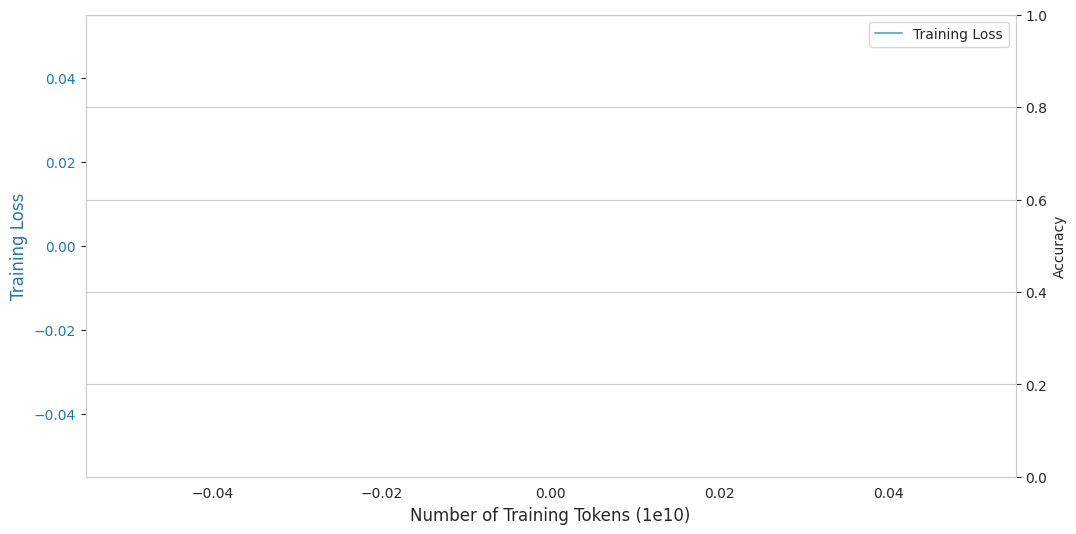

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_logs_from_history(log_history, batch_size_per_device, grad_accum_steps, seq_len=19042):
    """
    Parses the standard HF Trainer log format provided and plots:
    1. Training Loss (Left Axis)
    2. Eval Accuracy (Right Axis)
    vs Number of Tokens.
    """
    # Calculate effective batch size in tokens
    # Tokens per Step = Batch * GradAccum * SeqLen
    tokens_per_step = batch_size_per_device * grad_accum_steps * seq_len

    # Extract data
    train_data = {'tokens': [], 'value': []}
    eval_data = {'tokens': [], 'value': []}

    for entry in log_history:
        if 'step' not in entry:
            continue

        current_tokens = entry['step'] * tokens_per_step

        # 1. Capture Training Loss
        if 'loss' in entry:
            train_data['tokens'].append(current_tokens)
            train_data['value'].append(entry['loss'])

        # 2. Capture Eval Accuracy
        elif 'eval_accuracy' in entry:
            eval_data['tokens'].append(current_tokens)
            eval_data['value'].append(entry['eval_accuracy'])

    # Convert to DataFrames
    df_train = pd.DataFrame(train_data)
    df_eval = pd.DataFrame(eval_data)

    # --- Plotting ---
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Training Loss (Left Y-Axis)
    color_loss = 'tab:blue'
    sns.lineplot(
        data=df_train, x='tokens', y='value',
        ax=ax1, color=color_loss, label='Training Loss', alpha=0.6
    )
    ax1.set_xlabel('Number of Training Tokens (1e10)', fontsize=12)
    ax1.set_ylabel('Training Loss', color=color_loss, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color_loss)
    ax1.grid(False) # Turn off grid for primary to avoid clutter

    # Create Twin Axis for Accuracy (Right Y-Axis)
    ax2 = ax1.twinx()
    color_acc = 'tab:magenta' # Matching the paper's color for test

    if not df_eval.empty:
        sns.lineplot(
            data=df_eval, x='tokens', y='value',
            ax=ax2, color=color_acc, label='Validation Accuracy', linewidth=2.5, marker='o'
        )

    ax2.set_ylabel('Accuracy', color=color_acc, fontsize=12)
    ax2.tick_params(axis='y', labelcolor=color_acc)
    ax2.set_ylim(0, 1.0) # Accuracy is 0-1

    # Title and formatting
    plt.title('BulkRNABert Training Progress', fontsize=14)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # Scientific notation for tokens

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.tight_layout()
    plt.show()


# CONFIG parameters (Make sure these match your training run!)
BATCH_SIZE = 8   # per_device_train_batch_size
GRAD_ACCUM = 4   # gradient_accumulation_steps
SEQ_LEN = 19042  # N_genes

plot_logs_from_history(trainer.state.log_history, BATCH_SIZE, GRAD_ACCUM, SEQ_LEN)

In [6]:
# 2. Define your paths
# The folder you want to upload (e.g., your checkpoint)
source_folder = "./results_pretrain/checkpoint-765"

# Where you want it in Drive (this creates a 'Models' folder in your Drive root)
destination_folder = PROJECT_ROOT / "BulkRNABert_Models"

In [7]:
import subprocess

# Create destination directory
os.makedirs(destination_folder, exist_ok=True)

print(f"Copying files to {destination_folder}...")

# Use shell command for recursive copy (often faster than python shutil for massive folders)
# -r = recursive, -v = verbose (shows progress)
!cp -r -v "$source_folder" "$destination_folder"

print(" Copy complete.")

Copying files to /content/drive/MyDrive/bdh_challenge_2025_data/BulkRNABert_Models...
cp: cannot stat './results_pretrain/checkpoint-765': No such file or directory
 Copy complete.


In [ ]:
# Use the same preprocessor you used before (same global_max, bins)
preprocessor = RNAPreprocessor(num_bins=CONFIG['n_bins'])
tokenized_data = preprocessor.fit_transform(expr_aligned.values)  # numpy array

# Dataset for encoding (no survival here)
full_dataset = BulkRNADataset(tokenized_data)


In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = bert_encoder.to(device)
encoder.eval()

loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

all_embeddings = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        outputs = encoder(input_ids=input_ids)

        # Option 1: CLS embedding (first token)
        cls_emb = outputs.last_hidden_state[:, 0, :]   # (batch, 256)

        # Option 2 (alternative): mean-pool across genes
        # cls_emb = outputs.last_hidden_state.mean(dim=1)

        all_embeddings.append(cls_emb.cpu().numpy())

X_embed = np.vstack(all_embeddings)  # (n_samples, 256)
emb_df = pd.DataFrame(X_embed, index=expr_aligned.index)


In [ ]:
emb_df.to_parquet(PROCESSED_DIR / "tcga_bulkrnabert_embeddings.parquet")
